In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryDirectory

########################################################################
# The output of torchvision datasets are

# We transform them to Tensors of normalized range [-1, 1].

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size = 64
image_datasets = {
    'train': torchvision.datasets.Food101(root='./data', split='train',
                                    download=True, transform=data_transforms['train']),
    'test': torchvision.datasets.Food101(root='./data', split='test',
                                       download=True, transform=data_transforms['test'])
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size,
                                          shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size,
                                         shuffle=False, num_workers=4)
}

NUM_CLASSES = len(image_datasets['train'].classes)
DATA_DIR = './data/food-101'

CLASS_NAMES = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else device)
print(device)

cuda:0


In [2]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [3]:
# loading googlenet model
model_ft = models.googlenet(weights='IMAGENET1K_V1')
model_ft = model_ft.to(device)
num_ftrs = model_ft.fc.in_features

# Replaces last fully connected layer with a new one
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss().to(device)

## Freezing all parameters and unfreezes fc, last layer
for param in model_ft.parameters():
    param.requires_grad = False  # freeze all layers
for param in model_ft.fc.parameters():
    param.requires_grad = True
for param in model_ft.inception5b.parameters():  # Unfreeze the last inception block
    param.requires_grad = True
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\crise/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100.0%


In [4]:
# Benchmarking functions
import os
import torch
import matplotlib.pyplot as plt

def dir(name):
    if not os.path.exists(name):
        os.makedirs(name)

def save_benchmarks(best_acc, time_elapsed, test_loss, dir):
    with open(f'{dir}/benchmarks.txt', 'w') as f:
        f.write(f'Best Accuracy: {best_acc:.4f}\n')
        f.write(f'Training Time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s\n')
        f.write(f'Test Loss: {test_loss:.4f}\n')

def save_model(model, best_model_params_path, dir):
    torch.save(model.state_dict(), best_model_params_path)
    torch.save(model, f'{dir}/best_model.pth')

def plot_training_history(train_loss, test_loss, train_acc, test_acc, dir):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training loss')
    plt.plot(epochs, test_loss, 'ro-', label='Testing loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, test_acc, 'ro-', label='Testing accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig(f'{dir}/training_history.png')
    plt.show()
    
# Some variables to make code generic and readable
MODEL_NAME = 'googlenetWithUnfrozenBlock'
MODEL_DIR = f'benchmarks/{MODEL_NAME}'

In [5]:
from datetime import datetime

train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for batch, (inputs, labels) in enumerate(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    print(f'Batch: {batch} / {len(dataloaders[phase])}') if batch % 10 == 0 else None
                    
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                    train_acc_history.append(epoch_acc)
                else:
                    test_loss_history.append(epoch_loss)
                    test_acc_history.append(epoch_acc)

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best test Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

        # Create directories to save benchmarks
        dir(f'{MODEL_DIR}/stats')
        dir(f'{MODEL_DIR}/models')
        
        # Save benchmarks
        save_benchmarks(best_acc, time_elapsed, test_loss_history[-1], f'{MODEL_DIR}/stats')

        # Save the entire model
        current_time = datetime.now()
        formatted_time = current_time.strftime("%H-%M-%S")
        torch.save(model_ft, f'{MODEL_DIR}/models/{MODEL_NAME}-{formatted_time}.pth')

        # Plot training history and save plots
    return model

In [6]:
### Train and save model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
            num_epochs=15)

Epoch 0/14
----------
Batch: 0 / 1184
Batch: 10 / 1184
Batch: 20 / 1184
Batch: 30 / 1184
Batch: 40 / 1184
Batch: 50 / 1184
Batch: 60 / 1184
Batch: 70 / 1184
Batch: 80 / 1184
Batch: 90 / 1184
Batch: 100 / 1184
Batch: 110 / 1184
Batch: 120 / 1184
Batch: 130 / 1184
Batch: 140 / 1184
Batch: 150 / 1184
Batch: 160 / 1184
Batch: 170 / 1184
Batch: 180 / 1184
Batch: 190 / 1184
Batch: 200 / 1184
Batch: 210 / 1184
Batch: 220 / 1184
Batch: 230 / 1184
Batch: 240 / 1184
Batch: 250 / 1184
Batch: 260 / 1184
Batch: 270 / 1184
Batch: 280 / 1184
Batch: 290 / 1184
Batch: 300 / 1184
Batch: 310 / 1184
Batch: 320 / 1184
Batch: 330 / 1184
Batch: 340 / 1184
Batch: 350 / 1184
Batch: 360 / 1184
Batch: 370 / 1184
Batch: 380 / 1184
Batch: 390 / 1184
Batch: 400 / 1184
Batch: 410 / 1184
Batch: 420 / 1184
Batch: 430 / 1184
Batch: 440 / 1184
Batch: 450 / 1184
Batch: 460 / 1184
Batch: 470 / 1184
Batch: 480 / 1184
Batch: 490 / 1184
Batch: 500 / 1184
Batch: 510 / 1184
Batch: 520 / 1184
Batch: 530 / 1184
Batch: 540 / 1184

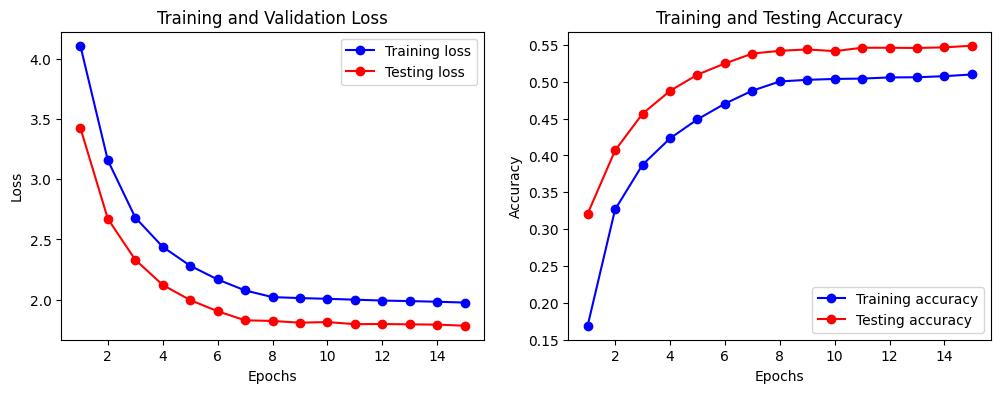

In [7]:
train_acc_history_copy = [acc.cpu() for acc in train_acc_history]
test_acc_history_copy = [acc.cpu() for acc in test_acc_history]
plot_training_history(train_loss_history, test_loss_history, train_acc_history_copy, test_acc_history_copy, f'{MODEL_DIR}/stats')

In [8]:
import random

def visualize_model_random(model, dir, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
                # Collect one image from 10 different random classes
        selected_images = []
        selected_labels = []
        class_count = {class_name: 0 for class_name in CLASS_NAMES}
        random_classes = random.sample(CLASS_NAMES, num_images)

        for inputs, labels in dataloaders['test']:
            for i in range(inputs.size(0)):
                class_name = CLASS_NAMES[labels[i].item()]
                if class_name in random_classes and class_count[class_name] < 1:
                    selected_images.append(inputs[i])
                    selected_labels.append(labels[i])
                    class_count[class_name] += 1
                    if len(selected_images) >= num_images:
                        break
            if len(selected_images) >= num_images:
                break

        inputs = torch.stack(selected_images).to(device)
        labels = torch.tensor(selected_labels).to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(num_images):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title(f'predicted: {CLASS_NAMES[preds[i]]}')
            imshow(inputs.cpu().data[i])
        
        # plt.savefig(f'{dir}/visual_test.png')
        plt.close(fig)

        model.train(mode=was_training)

        

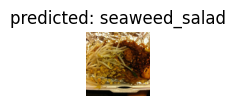

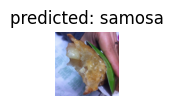

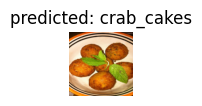

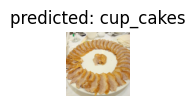

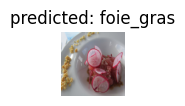

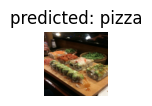

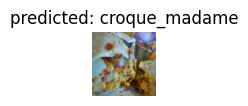

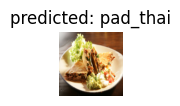

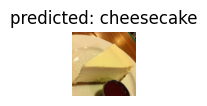

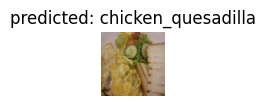

In [9]:
# Show the model's performance on a few test images
visualize_model_random(model_ft, f'{MODEL_DIR}/stats')

Most recently created model: benchmarks/googlenetWithUnfrozenBlock/models\googlenetWithUnfrozenBlock-20-50-56.pth


C:\Users\crise\AppData\Local\Temp\ipykernel_28444\2160714499.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(latest_model)


Batch: 0 / 395
Batch: 100 / 395
Batch: 200 / 395
Batch: 300 / 395


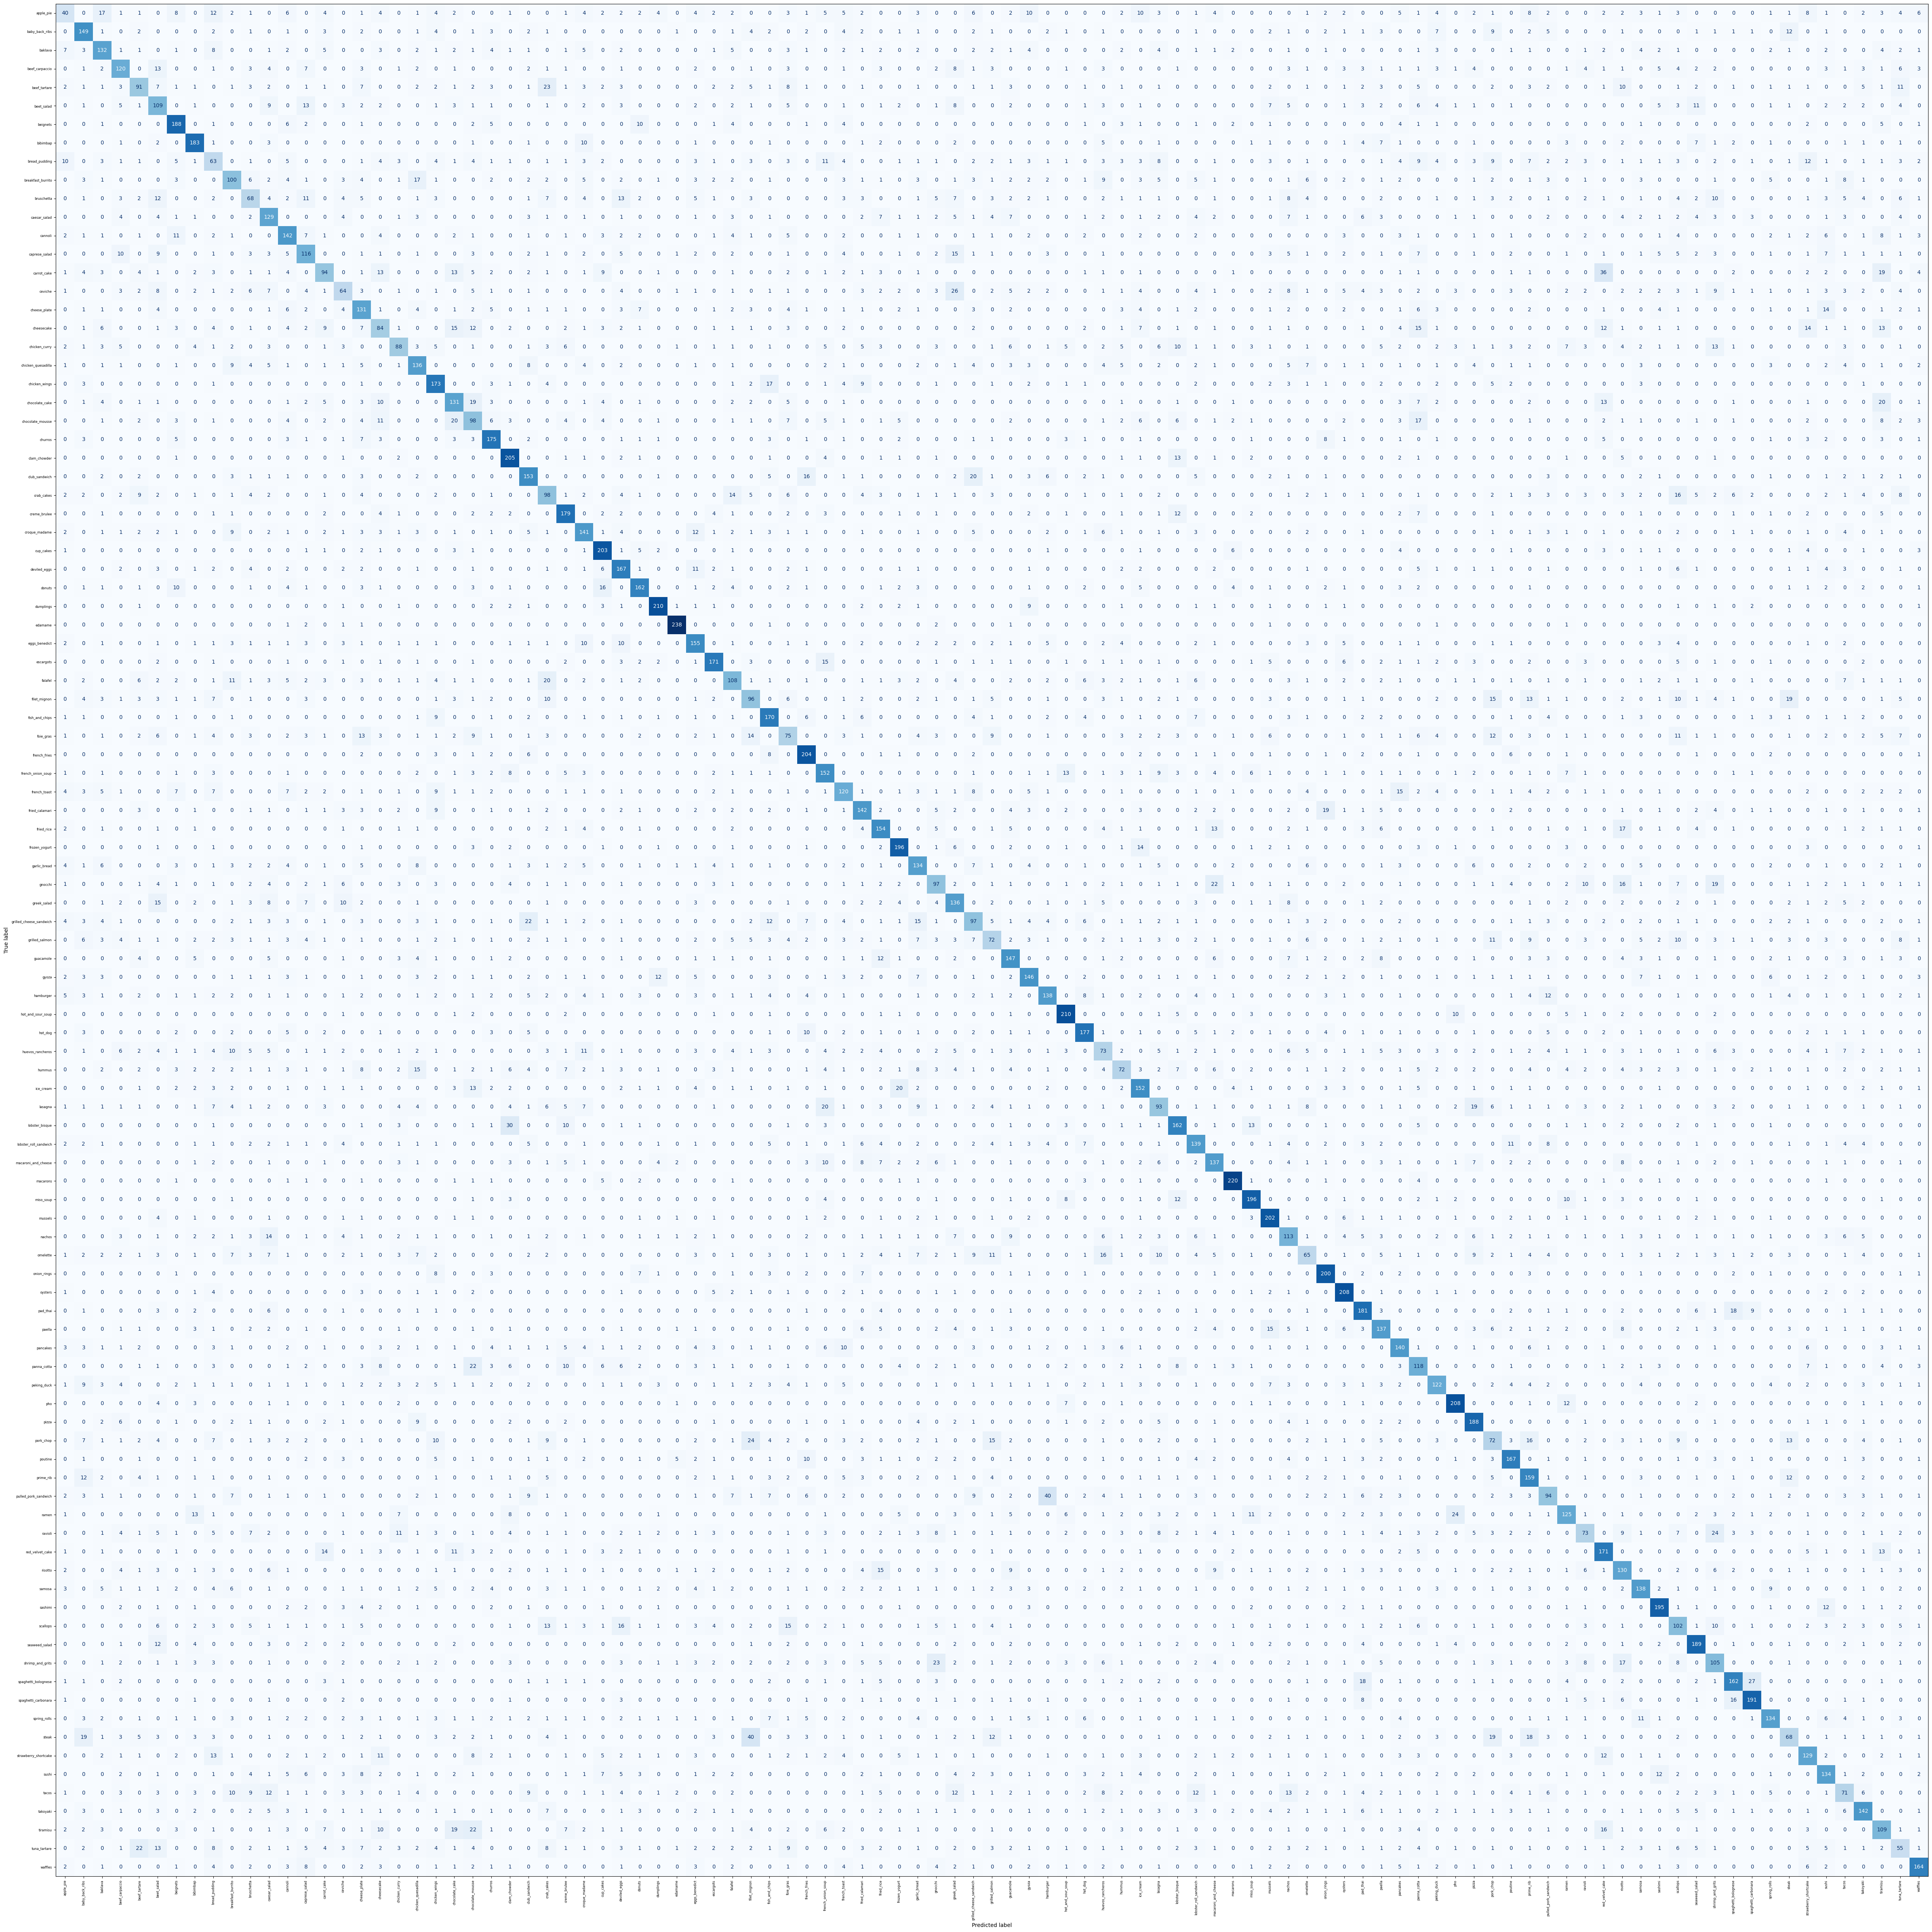

In [5]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchvision
import glob

folder_path = f'{MODEL_DIR}/models'
models = glob.glob(os.path.join(folder_path, '*'))
latest_model = max(models, key=os.path.getctime)

print('Most recently created model:', latest_model)

model = torch.load(latest_model)
model.to(device)
model.eval()

# Prepare your test dataset
all_preds = []
all_labels = []

# Disable gradient computation for inference
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        print(f'Batch: {i} / {len(dataloaders["test"])}') if i % 100 == 0 else None

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize the confusion matrix (optional but useful for large matrices)
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Increase figure size
fig, ax = plt.subplots(figsize=(50, 50), dpi=100)  # Adjust figsize as needed

# Create a ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(ax=ax, cmap='Blues', colorbar=False, xticks_rotation='vertical')

# Adjust font sizes
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.tight_layout()

# Save the plot with high resolution
plt.savefig(f'{MODEL_DIR}/stats/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

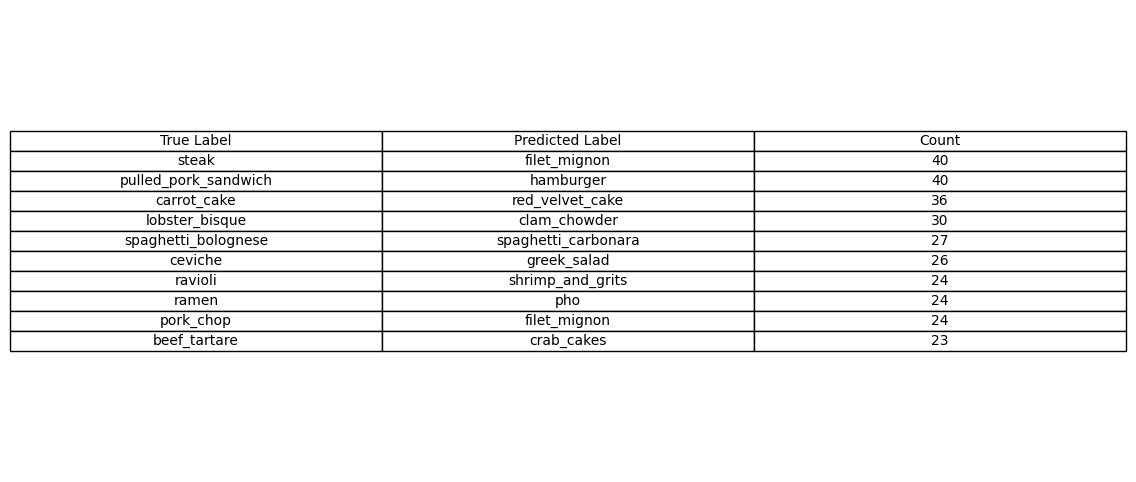

In [6]:
import pandas as pd

# Create a DataFrame of true labels and predictions
df_errors = pd.DataFrame({'True Label': all_labels, 'Predicted Label': all_preds})

# Map indices to class names
df_errors['True Label'] = df_errors['True Label'].apply(lambda x: CLASS_NAMES[x])
df_errors['Predicted Label'] = df_errors['Predicted Label'].apply(lambda x: CLASS_NAMES[x])

# Filter misclassifications
df_misclassifications = df_errors[df_errors['True Label'] != df_errors['Predicted Label']]

# Group by misclassifications
misclassifications = df_misclassifications.groupby(['True Label', 'Predicted Label']).size().reset_index(name='Count')

# Sort and display the top misclassifications
misclassifications = misclassifications.sort_values(by='Count', ascending=False)
top_misclassifications = misclassifications.head(10)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figsize as needed
ax.axis('off')  # Hide the axes

# Create the table
table = ax.table(
    cellText=top_misclassifications.values,
    colLabels=top_misclassifications.columns,
    cellLoc='center',
    loc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust scale for better readability

# Save the table as an image
plt.savefig(f'{MODEL_DIR}/stats/top_misclassifications_table.png', bbox_inches='tight', dpi=300)

# Display the table
plt.show()

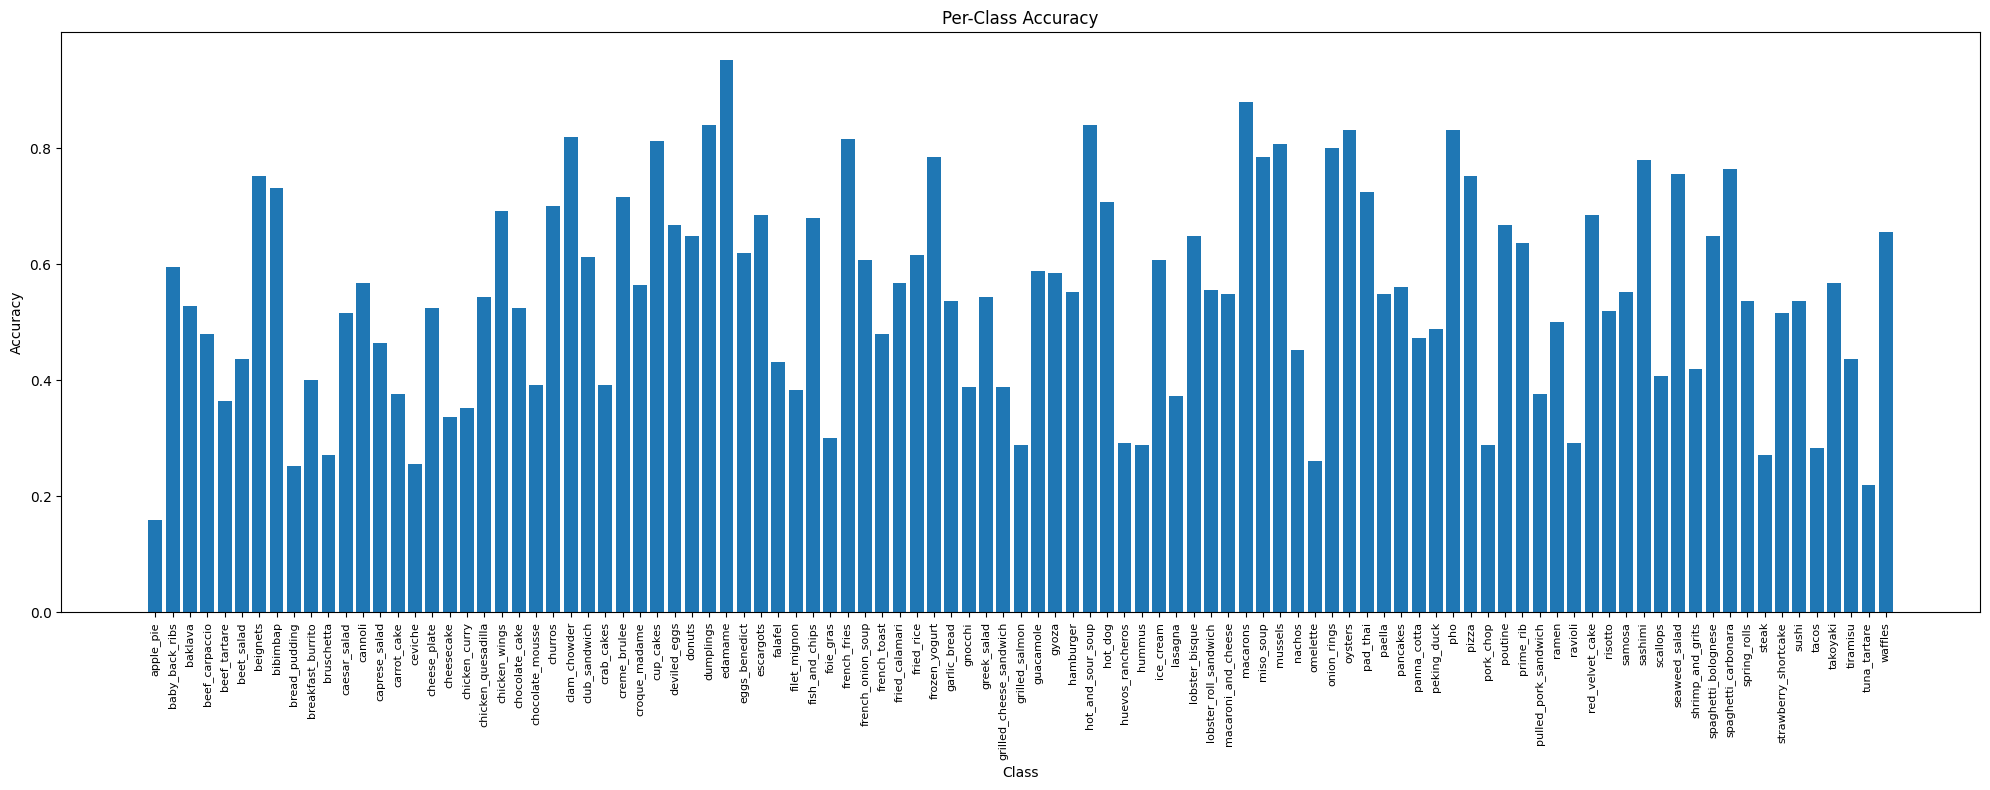

In [7]:
# Calculate per-class accuracy
per_class_correct = np.zeros(len(CLASS_NAMES))
per_class_total = np.zeros(len(CLASS_NAMES))

for label, pred in zip(all_labels, all_preds):
    per_class_total[label] += 1
    if label == pred:
        per_class_correct[label] += 1

per_class_accuracy = per_class_correct / per_class_total

# Plot per-class accuracy
plt.figure(figsize=(20, 8))
plt.bar(range(len(CLASS_NAMES)), per_class_accuracy)
plt.xticks(ticks=range(len(CLASS_NAMES)), labels=CLASS_NAMES, rotation='vertical', fontsize=8)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.tight_layout()

plt.savefig(f'{MODEL_DIR}/stats/class_accuracy_chart.png', bbox_inches='tight', dpi=300)
plt.show()